# Modelo *RMFT* ($\sigma^4$-$\omega$-$\boldsymbol{\rho}$) con electrones

In [1]:
# Importamos las librerias necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['font.size'] = 12
plt.rcParams['lines.markersize'] = 3
from scipy.interpolate import CubicSpline

import scripts.NSMatterEoS as NSEoS
import scripts.ResolverTOV as tov

## Ecuacion de Estado del Modelo

### Ecuaciones de la teoría

Consideramos la materia de estrellas de neutrones conformada por neutrones, protones y electrones e interacciones nucleares modeladas por el modelo RMFT ($\sigma^4$-$\omega$-$\boldsymbol{\rho}$). Para la estrella consideramos neutralidad de carga (igual proporción de protones y electrones), conservación de la densidad de partículas y equilibrio frente a decaimientos beta. 

Ahora, podemos escribir las ecuaciones de campo escalar, de equilibrio beta, de energía y presión empleando las variables y parámetros adimensionales $\tilde x_{\sigma} = 1-g_{\sigma}\sigma/m, \quad \tilde n = n/m^3, \quad x_i = p_i/m,\quad \tilde A_{i} = (g_i/m_i)^2m^2\,$; y la constante $\lambda = m^4$ con unidades de densidad de energía $\text{MeV/fm}^3$ o equivalentemente $\text{fm}^{-4}$

- Ecuación de campo escalar:

$$ (1-\tilde x_{\sigma}) - \tilde A_{\sigma}\left[\frac{1}{\pi^2} \left(\int_0^{x_{nF}(n)} \frac{\tilde x_{\sigma} x^2 dx}{\sqrt{x^2 + \tilde x_{\sigma}^2}} + \int_0^{x_{pF}(n)} \frac{\tilde x_{\sigma} x^2 dx}{\sqrt{x^2 + \tilde x_{\sigma}^2}} \right) - b (1-\tilde x_{\sigma})^2 - c (1-\tilde x_{\sigma})^3\right] = 0$$

- Ecuación de equilibrio beta, neutralidad de carga y conservación de la densidad de partículas:

$$ \sqrt{x_{nF}^2+\tilde x_\sigma^2} - \sqrt{x_{pF}^2+\tilde x_\sigma^2} -\sqrt{x_{pF}^2+\left(\frac{m_e}{m}\right)^2} - \frac{1}{6 \pi^2}\tilde A_\rho (x_{pF}^3-x_{nF}^3) = 0 $$
$$x_{pF} = \left(3\pi^2\tilde n-x_{nF}^3\right)^{1/3}$$

- Ecuaciones de energía y presión:

$$
\tilde\rho = \frac{\lambda}{2\rho_0} \Bigg[  (1-\tilde x_{\sigma})^2\left(\tilde A_{\sigma}^{-1} + \frac{2}{3} b(1-\tilde x_{\sigma}) + \frac{1}{2} c(1-\tilde x_{\sigma})^2\right) + \tilde n^2\tilde A_{\omega} + \frac{1}{36\pi^4} \tilde A_{\rho} (x_{pF}^3-x_{nF}^3)^2  \\
 + \frac{2}{\pi^2} \left(\int_0^{x_{nF}(n)} x^2 \sqrt{x^2 + \tilde x_{\sigma}^2} dx + \int_0^{x_{pF}(n)} x^2 \sqrt{x^2 + \tilde x_{\sigma}^2} dx + \int_0^{x_{pF}(n)} x^2 \sqrt{x^2 + \left(\frac{m_e}{m}\right)^2} dx\right) \Bigg]$$

$$
\tilde P = \frac{\lambda}{2\rho_0} \Bigg[  -(1-\tilde x_{\sigma})^2\left(\tilde A_{\sigma}^{-1} + \frac{2}{3} b(1-\tilde x_{\sigma}) + \frac{1}{2} c(1-\tilde x_{\sigma})^2\right) + \tilde n^2\tilde A_{\omega} + \frac{1}{36\pi^4} \tilde A_{\rho} (x_{pF}^3-x_{nF}^3)^2 \\

+ \frac{2}{3\pi^2} \left(\int_0^{x_{nF}(n)} \frac{x^4 dx}{\sqrt{x^2 + \tilde x_{\sigma}^2}} + \int_0^{x_{pF}(n)} \frac{x^4 dx}{\sqrt{x^2 + \tilde x_{\sigma}^2}} + \int_0^{x_{pF}(n)} \frac{x^4 dx}{\sqrt{x^2 + \left(\frac{m_e}{m}\right)^2}}\right) \Bigg]
$$


### Constantes y parámetros del modelo

In [2]:
# Definimos las constantes necesarias en MKS
hbar_MKS = 1.0545718e-34 # J s
c_MKS = 299792458 # m/s
G_MKS = 6.67430e-11 # m^3/kg/s^2
pi = np.pi
proton_mass = 1.6726219e-27 # kg
neutron_mass = 1.6749275e-27 # kg
electron_mass = 9.1093837e-31 # kg
m_nuc_MKS = (proton_mass + neutron_mass)/2.0 # kg
e_MKS = 1.6021766e-19 # J

# Algunas converciones útiles (multiplicar al primero para obtener el segundo)
Kg_to_fm11 = c_MKS/hbar_MKS*1e-15 # kg to fm^-1
MeV_to_fm11 = e_MKS/(hbar_MKS*c_MKS*1e9) # MeV to fm^-1
MeVfm_to_Jm  = 1e51*e_MKS # MeV/fm^3 to J/m^3

# Definimos las constantes necesarias en unidades naturales
m_nuc = m_nuc_MKS * Kg_to_fm11 # fm^-1
m_e = electron_mass * Kg_to_fm11 # fm^-1

# Damos valores a las constantes (Glendenning K=200 m*/m=0.7) (constantes tilde cuadradas)
A_sigma = 12.684*m_nuc**2 # Walecka: 266.9, 357.4
A_omega =  7.148*m_nuc**2 # Walecka: 195.7, 273.8
A_rho   =  4.410*m_nuc**2 # Nuevo parámetro para el campo rho
b       =  5.610e-3       # Parametros de autointeracción del campo sigma
c       = -6.986e-3

params = [A_sigma, A_omega, A_rho, b, c]

### Ecuación de estado numérica

In [3]:
# Calculamos si no hay archivo de la EoS, si no, lo leemos
operacion = 'calc' # 'calc' o 'leer'

if operacion == 'calc':
    # Definimos el rango de densidades para la interpolación de la EoS
    densidad_masa_max = 1e18*1e3*(1e-45/m_nuc_MKS) # g/cm^3 a kg/m^3 a 1/fm^3
    densidad_masa_min = 1e12*1e3*(1e-45/m_nuc_MKS) # g/cm^3 a kg/m^3 a 1/fm^3
    n_barions = np.logspace(np.log10(densidad_masa_min), np.log10(densidad_masa_max), 200)
    # Calculamos la EoS
    rho_P, presiones, energias, n_sirve, presion_cambio = NSEoS.EoS(n_barions, params)
    df = pd.DataFrame({'n': n_sirve[presion_cambio:], 'P': presiones[presion_cambio:], 'E': energias[presion_cambio:]})
    df.to_csv('EoS_tables/NSMatter_A_Glendenning.csv', index=False, float_format='%.15e')
elif operacion == 'leer':
    # Leemos los resultados de la EoS
    df = pd.read_csv('EoS_tables/NSMatter_A_Glendenning.csv')
    n_sirve = df['n'].values
    presiones = df['P'].values
    energias = df['E'].values
    rho_P = CubicSpline(presiones, energias)
    presion_cambio = False

c:\Users\nicom\Desktop\CalculosSimulaciones\NS_Structure\scripts\NSMatterEoS.py:60: RuntimeWarning: invalid value encountered in scalar power
  x_pF = ( (3.0*pi**2)*n_barion/m_nuc**3 - x_nF**3)**(1/3) # Momento de Fermi del protón (y electrón)


## Solución de las Ecuaciones Hidrostáticas

In [6]:
# Si la variable presion_cambio no es false, redefinimos los arrays
if presion_cambio:
    # Definimos la densidad de bariones y la presión para la integración del sistema
    n_sirve = n_sirve[presion_cambio:]
    presiones = presiones[presion_cambio:]
    energias = energias[presion_cambio:]
    rho_P = CubicSpline(presiones, energias)

# Definimos la ecuacion de estado para la integración del sistema
print("Primer densidad de barinoes util", "{:2.2e}".format(n_sirve[0]), "1/fm^3 por ende densidad de masa", format(n_sirve[0]*1e45*m_nuc_MKS*1e-3,"2.2e"), "g/cm^3 y presión", format(presiones[0], "2.2e"), "adimensional")
densidad_limite = energias[0] # Densidad de energia límite adimensional para rho_0 = lambda/2
P_rho = CubicSpline(energias, presiones) # Presión en función de la densidad de energía para rho_0 = lambda/2
P_central = P_rho(1) # Presión central en unidades adimensionales para rho_0 = lambda/2

# Definimos los parametros de integración
rf = 20 # Radio final adimensional
dr = 1e-3 # Paso de integración adimensional

# Resolvemos el sistema TOV
rho_nat_to_MKS = 1.0 / MeV_to_fm11 * MeVfm_to_Jm
sol_final = tov.integrador(rf, dr, (m_nuc**4/2)*rho_nat_to_MKS, rho_P, P_central, densidad_limite=densidad_limite)
# Orden: r, m, rho, P, phi
print("Radio final = ", sol_final[0]/1e3, "km, Masa final = ", sol_final[1]/1.989e30, "M_sun")
# tov.graficar_solucion(rf, dr, rho_0_lambda, rho_P, P_central, densidad_limite=densidad_limite)

Primer densidad de barinoes util 2.06e-02 1/fm^3 por ende densidad de masa 3.45e+13 g/cm^3 y presión 3.57e-09 adimensional
Radio final =  8.83738315387232 km, Masa final =  1.664609959554213 M_sun


c:\Users\nicom\Desktop\CalculosSimulaciones\NS_Structure\scripts\NSMatterEoS.py:60: RuntimeWarning: invalid value encountered in scalar power
  x_pF = ( (3.0*pi**2)*n_barion/m_nuc**3 - x_nF**3)**(1/3) # Momento de Fermi del protón (y electrón)
c:\Users\nicom\Desktop\CalculosSimulaciones\NS_Structure\scripts\ResolverTOV.py:163: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol = odeint(ecuaciones, [P0, m0, phi0], r, args=(rho_P,)).T


Masa máxima: 2.331 M_sun para rho0_m = 1.493e+15 g/cm^3


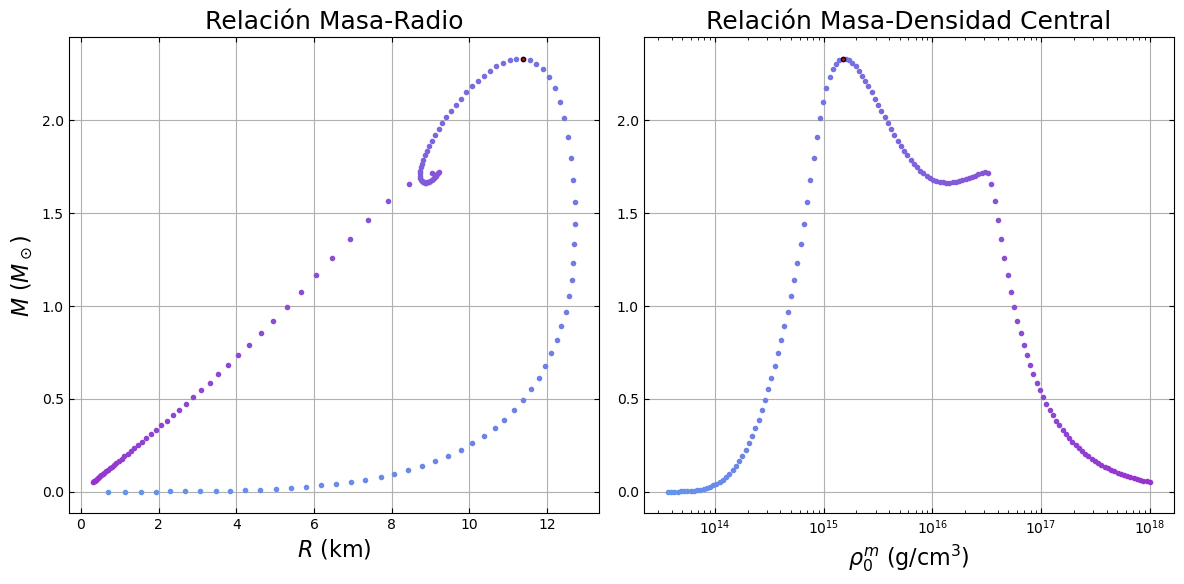

In [7]:
# Definimos el espacio de densidades centrales de masa para la integración
rhos_masa = np.logspace(np.log10(n_sirve[1]*1e45*m_nuc_MKS*1e-3), 18, 150) # Densidades de masa en kg/m^3 (desde donde es util la EoS)
# rhos_masa = np.logspace(14, 18, 100) # Densidades de masa en kg/m^3

# Calculamos la densidad de energía asociada a cada densidad de masa
rhos = []
for rho_m in rhos_masa:
    densidad_energia, sols_ = NSEoS.energia_presion(rho_m*1e3/m_nuc_MKS*1e-45, params)
    rhos.append(densidad_energia)
    
# Definimos arrays para la masa y el radio
masas = np.zeros(len(rhos))
radios = np.zeros(len(rhos))

# Resolvemos el sistema TOV para cada densidad central de masa
arg_max = 0
for i in range(len(rhos)):
    rho0 = rhos[i] # Densidad de energía central adimensionalizada con rho_0_lambda
    R = 1.0/rho0 # Factor de conversión para la interpolación adimensionalizada con rho0
    rho_P_prima = lambda P: R*rho_P(P/R) # Interpolación adimensionalizada con rho0 (en función de P adimensional con rho0)
    P_central_prima = R*P_rho(1/R) # Presión central adimensionalizada con rho0
    densidad_limite_prima = R*densidad_limite # Densidad de energía límite adimensionalizada con rho0
    sol_final = tov.integrador(rf, dr, rho0*(m_nuc**4/2)*rho_nat_to_MKS, rho_P_prima, P_central_prima, densidad_limite=densidad_limite_prima)
    radios[i] = sol_final[0] # Radio final en metros
    masas[i] = sol_final[1] # Masa final en kg
    if masas[i] > masas[arg_max]:
        arg_max = i
    # print("Se pudo para densidad de masa =", format(rho_m,"2.2e"), "g/cm^3")
    
# Guardamos los resultados en un archivo MasaRadio_SigmaOmegaRho_rho0_lambda_A_propios.csv
m_sun = 1.989e30 # kg
df = pd.DataFrame({'Masa': masas/m_sun, 'Radio': radios*1e-3, 'rho_m': rhos_masa})
df.to_csv('results/MasaRadio_SigmaOmegaRho_rho0_lambda_A_propios.csv', index=False, float_format='%.15e')
    
# Graficamos la relación masa-radio
tov.grafica_masa_radio(radios, masas, rhos_masa)

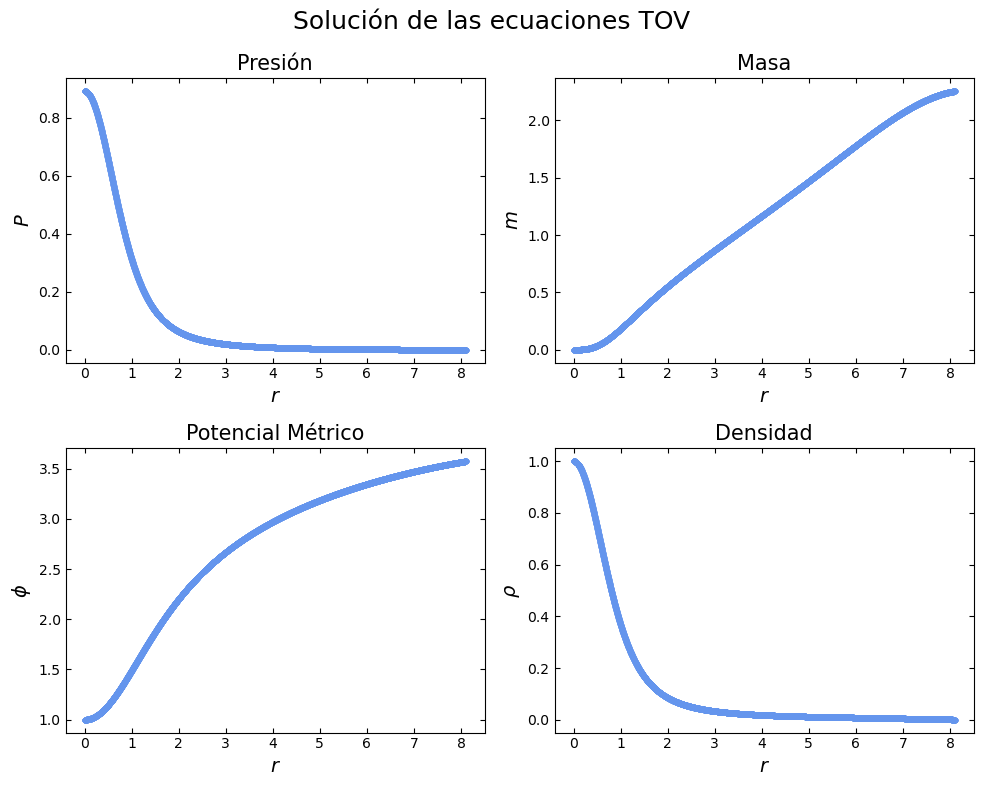

In [8]:
tov.graficar_solucion(rf, dr, (m_nuc**4/2)*rho_nat_to_MKS, rho_P, P_central, densidad_limite=densidad_limite)

## Resultados de la EoS

### Superficies de Autoconsistencia

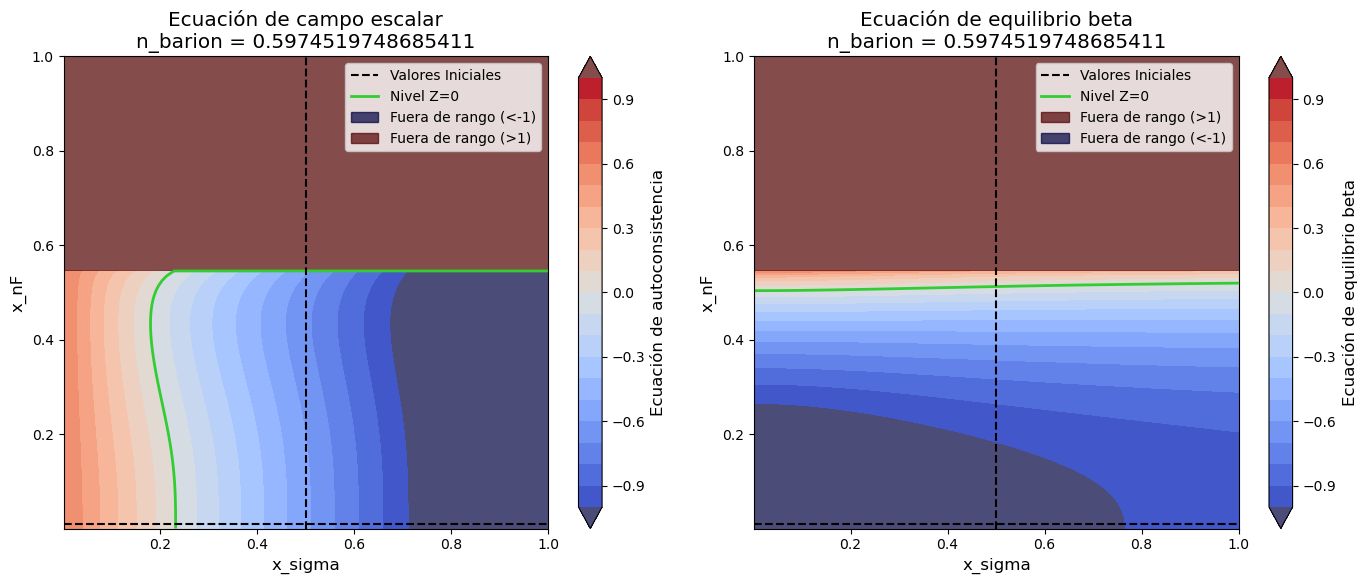

Solución encontrada para n_barion = 0.5974519748685411 : [0.19238404 0.50640469]


array([-2.22044605e-16,  1.94289029e-16])

In [66]:
dens_ = (1e15)*(1e3/m_nuc_MKS*1e-45) # g/cm^3 a 1/fm^3
sols_ = NSEoS.sol_x_sigma_x_nF(dens_, params, [0.5,0.01], True, 'lm')
# sols_ = NSEoS.sol_x_sigma_x_nF(dens_, params, [np.exp(-dens_*10),dens_**(1/3)/2], True, 'lm')
NSEoS.ecuaciones_autoconsistencia(sols_, dens_, params)

### Ecuación de autoconsistencia

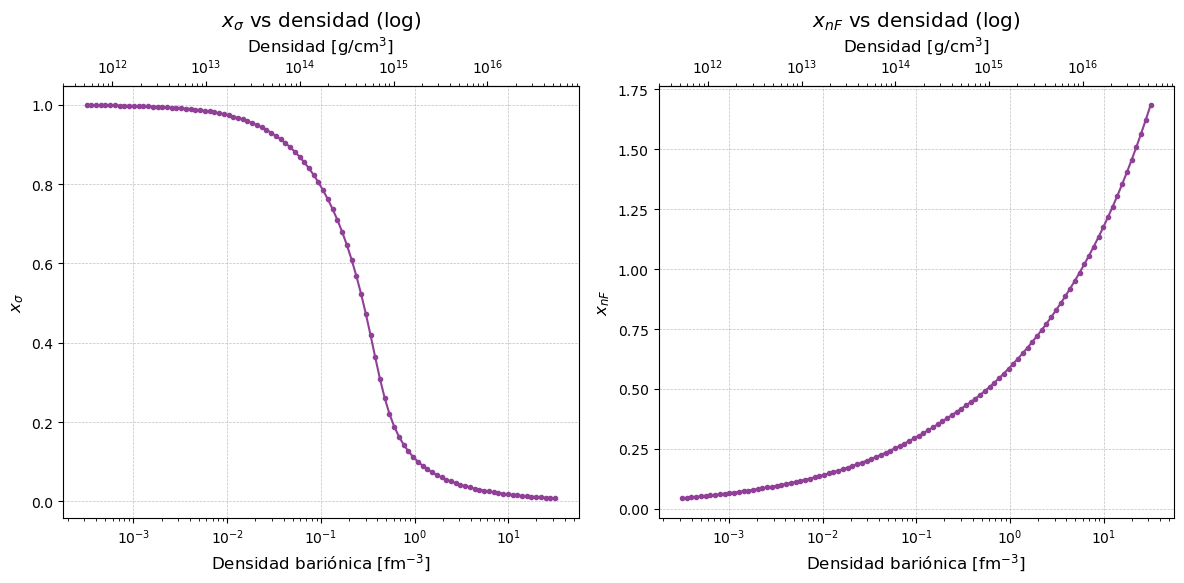

In [4]:
# Testeamos las soluciones de autoconsistencia
n_prove = np.logspace(-3.5, 1.5, 100) 
NSEoS.plot_autoconsistencia(n_prove, params)

### Interpolación y ecuación de estado

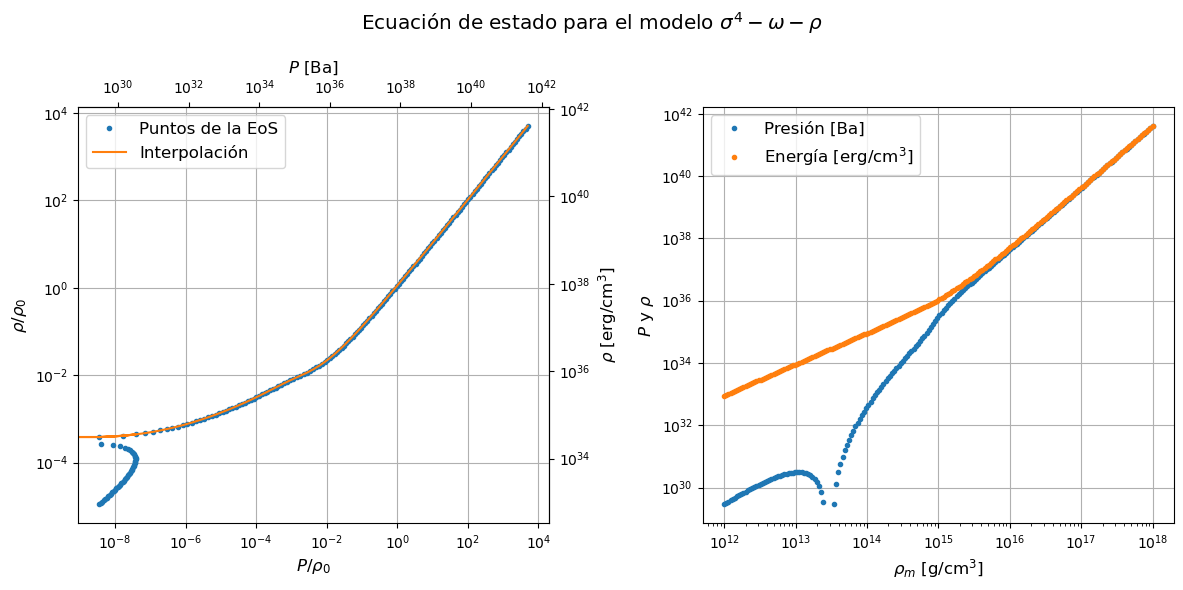

In [5]:
NSEoS.plot_EoS(rho_P, presiones, energias, n_sirve, titulo=r'Ecuación de estado para el modelo $\sigma^4-\omega-\rho$')

### Observables $\frac{B}{A}$, $n_{sat}$, $K_{sat}$ y $a_{sym}$

La masa efectiva en saturación es: 0.997 m_nuc
Densidad de saturación n_saturacion = 0.001 1/fm^3 ( 1.674e+12 g/cm^3 ) y energia de enlace por nucleon en saturación = 0.759 MeV y densidad de energia en saturación = 0.940 MeV/fm^3
Presion en la densidad de saturación: 5.887316926444238e+28 Pa


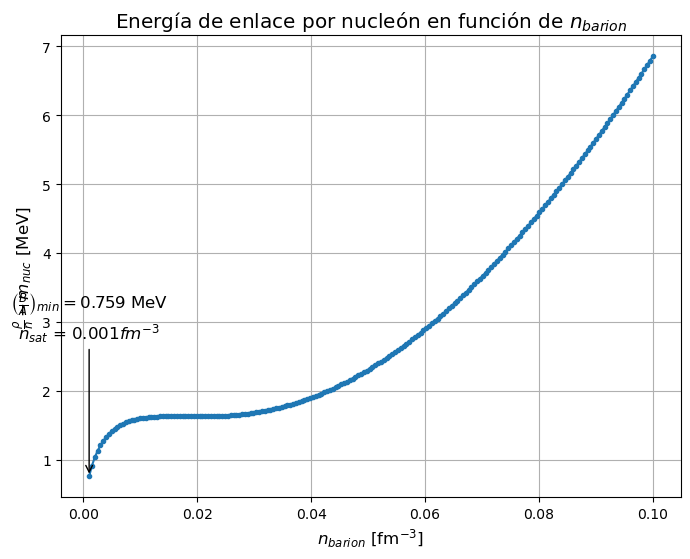

In [4]:
# Graficamos la energia de enlace por nucleon vs la densidad de bariones
# n_prove = np.logspace(-3, -0.5, 200) # Densidades de bariones en fm^-3
n_prove = np.linspace(1e-3, 0.1, 200) # Densidades de bariones en fm^-3
saturacion = NSEoS.plot_saturacion(n_prove, params)

In [5]:
# Calculamos el modulo de compresion y el coeficiente de energía de simetría
# K = NSEoS.modulo_compresion(saturacion[0], params)
# print(f'Modulo de compresion: {K:.4f} MeV')

a_sym = NSEoS.coeficiente_simetria(saturacion[0], params)
print(f'Coeficiente de simetria: {a_sym:.4f} MeV')

Coeficiente de simetria: 0.5261 MeV


Propiedades para -0.0:
  Saturación: 0.1533 fm^-3
  Energía de enlace: -16.3020 MeV
  Módulo de compresión: 201.0481 MeV
  Coeficiente de simetría: 32.5343 MeV
La masa efectiva en saturación es: 0.700 m_nuc
Densidad de saturación n_saturacion = 0.153 1/fm^3 ( 2.565e+14 g/cm^3 ) y energia de enlace por nucleon en saturación = -16.302 MeV y densidad de energia en saturación = 141.410 MeV/fm^3
Presion en la densidad de saturación: 1.0928305940687052e+30 Pa


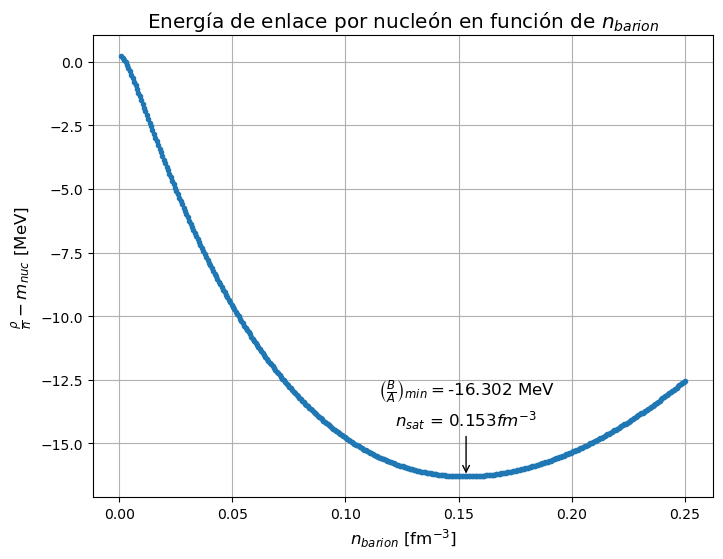

[np.float64(0.15327067669172934), np.float64(-16.30201321153912)]

In [ ]:
# Calculamos las propiedades para un cierto t
n_prove = np.linspace(1e-3, .25, 400) # Densidades de bariones en fm^-3
# n_prove = np.logspace(-3, -0.5, 200) # Densidades de bariones en fm^-3
t_test = -0.0
properties = NSEoS.calculate_properties(n_prove, [A_sigma, A_omega, A_rho, b, c, t_test]) # t=0.0 para simetría
print(f'Propiedades para {t_test:.1f}:')
print(f'  Saturación: {properties[0]:.4f} fm^-3')
print(f'  Energía de enlace: {properties[1]:.4f} MeV')
print(f'  Módulo de compresión: {properties[2]:.4f} MeV')
print(f'  Coeficiente de simetría: {properties[3]:.4f} MeV')
NSEoS.plot_saturacion(n_prove, [A_sigma, A_omega, A_rho, b, c, t_test])

# Trash Can

Text(0.5, 1.0, '$\\tilde n = 0.161$')

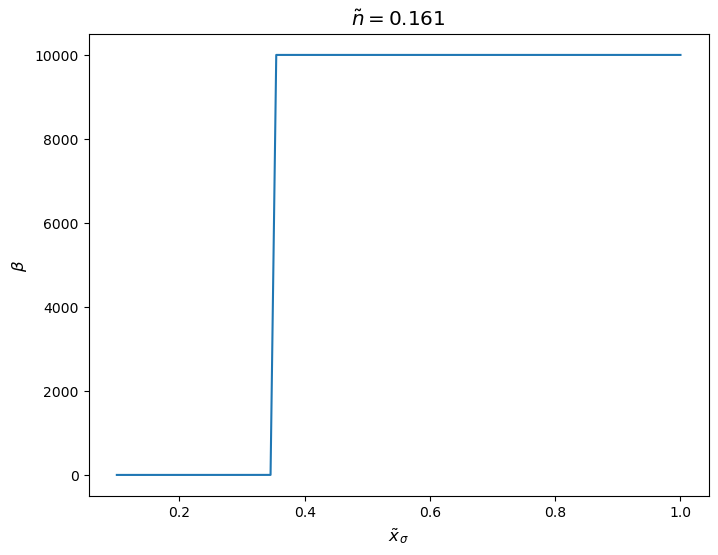

In [ ]:
den = 0.161
x_n=0.2
x_sigmas = np.linspace(0.1, 1, 100)
betas = np.zeros_like(x_sigmas)
for i in range(len(x_sigmas)):
    betas[i] = NSEoS.ecuaciones_autoconsistencia([x_sigmas[i], x_n], den, params)[1]
    
plt.plot(x_sigmas, betas)
plt.xlabel(r'$\tilde x_\sigma$')
plt.ylabel(r'$\beta$')
plt.title(r'$\tilde n = %.3f$' % den)